In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
from tqdm import tqdm
import pickle as pkl
import pandas as pd

from ex_simulation import p
from dset import get_dataloader, load_pretrained_model

# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform1d import DWT1d
from utils import get_1dfilts, get_wavefun, dist
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_1dreconstruct, plot_wavefun

# evaluation
from matplotlib import gridspec
from matplotlib.ticker import MaxNLocator
from eval_simulation import load_results

# load results

In [2]:
waves = ["db5", "sym5", "coif2"]
# result path
path = opj(os.getcwd(), "results")
dirs = [wave + "_saliency_warmstart_seed=1" for wave in waves]
dics, results, models = load_results(dirs, waves, path)

# wavelet with min L1 distance

In [3]:
wlist = []
for i in range(len(dirs)):
    res = results[i]
    lamL1wave = np.array(res['lamL1wave'])
    lamL1attr = np.array(res['lamL1attr'])
    lamL1wave_grid = np.unique(lamL1wave)
    lamL1attr_grid = np.unique(lamL1attr)
    R = len(lamL1wave_grid)
    C = len(lamL1attr_grid)    
    
    # collect results
    dic = {'bestAWD': {},
           'init': {},
           'h': {},
           'x': {},
           'curve': {},
           'lam': {},
           'gam': {}}
    
    min_dist = min(dics[i]['dist'].values())
    r, c = [key for key in dics[i]['dist'] if dics[i]['dist'][key] == min_dist][0]
    wt = dics[i]['wt'][(r,c)]
    phi, psi, x = get_wavefun(wt)
    
    # initialization
    if waves[i] == 'db5':
        torch.manual_seed(p.seed) 
        wt_i = DWT1d(wave=waves[i], mode='zero', J=4, init_factor=1, noise_factor=0.3).to(device)
    else:
        wt_i = DWT1d(wave=waves[i], mode='zero', J=4, init_factor=1, noise_factor=0.0).to(device)        
    phi_i, psi_i, x_i = get_wavefun(wt_i)  
    
    
    dic['bestAWD'] = psi
    dic['init'] = psi_i
    dic['x'] = x
    dic['h'] = wt_i.h0.detach().squeeze().cpu().numpy()
    
    lam = dics[i]['lamL1wave'][(r,c)]
    gam = [dics[i]['lamL1attr'][(r,c)] for c in range(C)]
    curve = [dics[i]['dist'][(r,c)] for c in range(C)]
    dic['lam'] = lam
    dic['gam'] = gam
    dic['curve'] = curve
    
    wlist.append(dic)

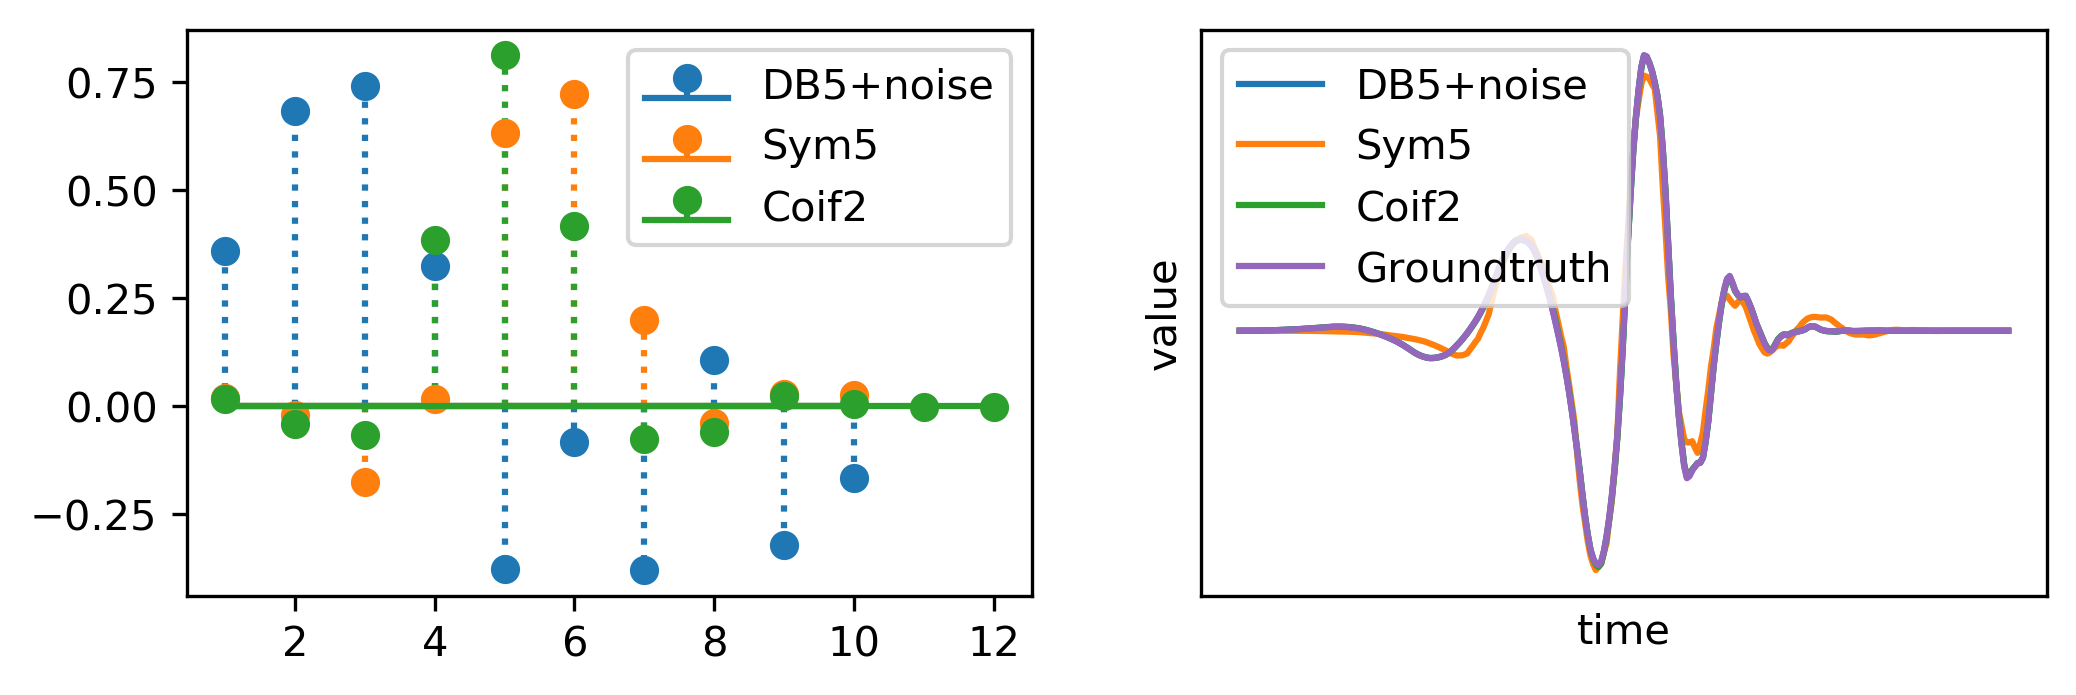

In [4]:
fig = plt.figure(dpi=300, figsize=(8,2.5))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
labels = ['DB5+noise', 'Sym5', 'Coif2']

ax_00 = fig.add_subplot(spec[0, 0])
h_i_db5 = np.pad(wlist[0]['h'], (1,1), mode='constant', constant_values=(0,0))
h_i_sym5 = np.pad(wlist[1]['h'], (1,1), mode='constant', constant_values=(0,0))
h_i_db5 = wlist[0]['h']
h_i_sym5 = wlist[1]['h']
h_i_coif2 = wlist[2]['h']
ax_00.stem(np.arange(1,11), h_i_db5, label='DB5+noise', linefmt='C0:', basefmt='C0-', markerfmt='C0o', use_line_collection=True)
ax_00.stem(np.arange(1,11), h_i_sym5, label='Sym5', linefmt='C1:', basefmt='C1-', markerfmt='C1o', use_line_collection=True)
ax_00.stem(np.arange(1,13), h_i_coif2, label='Coif2', linefmt='C2:', basefmt='C2-', markerfmt='C2o', use_line_collection=True)
ax_00.legend(loc='upper right')
ax_00.xaxis.set_major_locator(MaxNLocator(integer=True))

ax_01 = fig.add_subplot(spec[0, 1])
x = wlist[1]['x']
psi_db5 = wlist[0]['bestAWD']
psi_sym5 = wlist[1]['bestAWD']
psi_coif2 = wlist[2]['bestAWD'][32:-32]
ax_01.plot(x/np.max(x), psi_db5, label='DB5+noise', linewidth=1.5, alpha=1.0, color='C0')
ax_01.plot(x/np.max(x), np.roll(psi_sym5[::-1],-5), label='Sym5', linewidth=1.5, alpha=1.0, color='C1')
ax_01.plot(x/np.max(x), np.roll(psi_coif2,2), label='Coif2', linewidth=1.5, alpha=1.0, color='C2')
# original wavelet
wt_o = DWT1d(wave='db5', mode='zero', J=4).to(device)
phi_o, psi_o, x_o = get_wavefun(wt_o)
ax_01.plot(x/np.max(x), psi_o, label='Groundtruth', linewidth=1.5, alpha=1.0, color='C4')
ax_01.get_xaxis().set_ticks([])
ax_01.get_yaxis().set_ticks([])
ax_01.set_xlabel('time')
ax_01.set_ylabel('value')  
ax_01.legend(loc='upper left')

# plt.savefig('figures/sim_main.pdf', bbox_inches='tight')

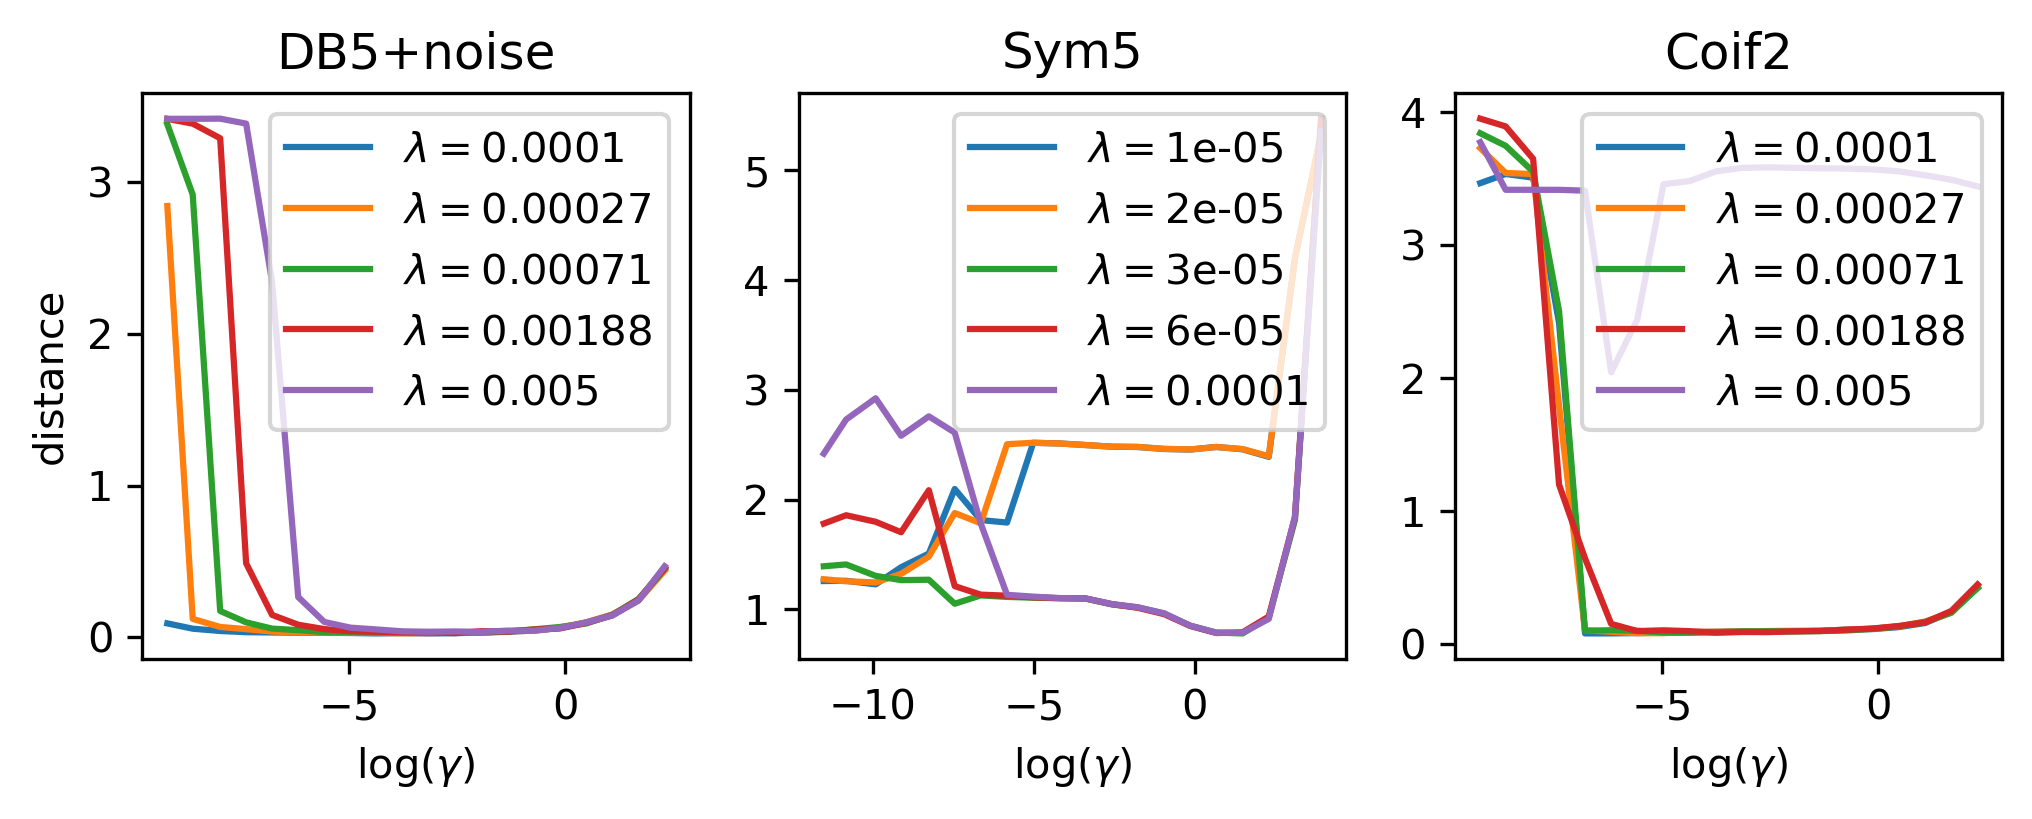

In [5]:
# plot
num_rows = 1
num_cols = 3
titsize = 6
labels = ['DB5+noise', 'Sym5', 'Coif2']

fig = plt.figure(dpi=300, figsize=(8,2.5))

for i in range(len(dirs)):
    res = results[i]
    lamL1wave = np.array(res['lamL1wave'])
    lamL1attr = np.array(res['lamL1attr'])
    lamL1wave_grid = np.unique(lamL1wave)
    lamL1attr_grid = np.unique(lamL1attr)
    R = len(lamL1wave_grid)
    C = len(lamL1attr_grid)
    
    # distance plot
    plt.subplot(num_rows, num_cols, i + 1)
    for r in range(R):
        d_array = [dics[i]['dist'][(r,c)] for c in range(C)]
        plt.plot(np.log(lamL1attr_grid[1:]), d_array[1:], label='$\lambda=$'+str(lamL1wave_grid[r]))
    plt.xlabel('$\log(\gamma)$')
    if i == 0:
        plt.ylabel('distance')    
    plt.legend(loc='upper right')  
    plt.title(labels[i])

# plt.savefig('figures/sim_dist.pdf', bbox_inches='tight')